# Library Import

In [1]:
import numpy as np
from scipy.optimize import least_squares, minimize
from sklearn.metrics import (mean_squared_error,
                             root_mean_squared_error, mean_absolute_error,
                             mean_absolute_percentage_error, r2_score)
import matplotlib.pyplot as plt

# Load Data

t: time  
f: failures  
cum_f: cumulative failures

In [2]:
data = np.loadtxt('J2.csv', delimiter=',', skiprows=1, dtype=int)
data = np.insert(data, 0, [0, 0, 0], axis=0)

In [3]:
t = data[:, 0]
f = data[:, 1]
cum_f = data[:, 2]

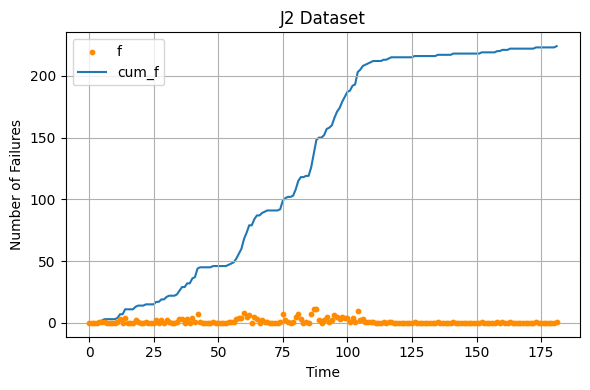

In [4]:
plt.figure(figsize=(6, 4))

plt.scatter(t, f, color='darkorange', s=10, label='f', zorder=2)
plt.plot(t, cum_f, label='cum_f', zorder=1)

plt.title('J2 Dataset')
plt.xlabel('Time')
plt.ylabel('Number of Failures')
plt.legend()
plt.grid()
plt.tight_layout()

plt.show()

# Estimation

Preparation functions for parameter estimation

In [5]:
tiny = np.finfo(float).tiny  # Prevent log calculation errors (avoid log(0))


# Goel-Okumoto model function
def goel_okumoto(t, a, b):
    return a * (1 - np.exp(-b * t))


# Residual function for LSM estimation using Goel-Okumoto model
def goel_okumoto_lsm(params, t, cum_f):
    a, b = params
    return goel_okumoto(t, a, b) - cum_f


# Function to estimate parameter 'a' of the Goel-Okumoto model
def goel_okumoto_a(t, f, b):
    a = f / (1 - np.exp(-b * t))
    return a


# Negative log-likelihood function for the Goel-Okumoto model
def goel_okumoto_nll(params, t, f):
    b = params
    a = np.sum(f) / (1 - np.exp(-b * t[-1]))

    term1 = a * (np.exp(-b * t[:-1]) - np.exp(-b * t[1:]))
    term1[term1 < tiny] = tiny
    log_term1 = f[1:] * np.log(term1)

    term2 = a * (np.exp(-b * t[0]) - np.exp(-b * t[-1]))

    log_facs = [np.sum([np.log(j) for j in range(1, i+1)]) for i in f[1:]]

    loglikelihood = np.sum(log_term1) - term2 - np.sum(log_facs)
    return -loglikelihood

Setup variables for parameter estimation

In [6]:
eps = np.sqrt(np.finfo(float).eps)  # Small epsilon to avoid division by zero

# Parameter initialization and bounds for LSM estimation
lsm_init_guess = [cum_f[-1] * 1.5, 0.1]
lsm_bounds = ([cum_f[-1], eps], [np.inf, np.inf])

# Parameter initialization and bounds for MLE estimation
mle_init_guess = [0.1]
mle_bounds = [(eps, np.inf)]

## LSM

### Trust Region Reflective algorithm

In [7]:
result = least_squares(goel_okumoto_lsm, lsm_init_guess, args=(t, cum_f),
                       method='trf', bounds=lsm_bounds)

trf_a, trf_b = result.x
print(f'a: {trf_a}, b: {trf_b}')

a: 1089.8443934742647, b: 0.0015011864551625193


In [8]:
f_pred = goel_okumoto(t, trf_a, trf_b)

print(f'MSE: {mean_squared_error(cum_f, f_pred)}')
print(f'RMSE: {root_mean_squared_error(cum_f, f_pred)}')
print(f'MAE: {mean_absolute_error(cum_f, f_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(cum_f, f_pred)}')
print(f'R2 score: {r2_score(cum_f, f_pred)}')

MSE: 613.9177688004733
RMSE: 24.777364040601118
MAE: 21.882511246801375
MAPE: 242481418868109.5
R2 score: 0.9173248369717377


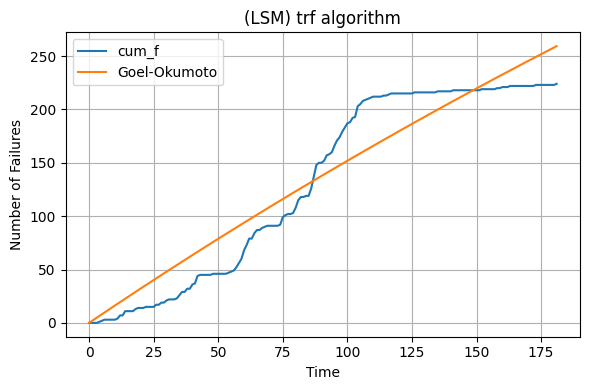

In [9]:
plt.figure(figsize=(6, 4))

plt.plot(t, cum_f, label='cum_f')
plt.plot(t, f_pred, label='Goel-Okumoto')

plt.title('(LSM) trf algorithm')
plt.xlabel('Time')
plt.ylabel('Number of Failures')
plt.legend()
plt.grid()
plt.tight_layout()

plt.show()

### dogleg algorithm

In [10]:
result = least_squares(goel_okumoto_lsm, lsm_init_guess, args=(t, cum_f),
                       method='dogbox', bounds=lsm_bounds)

dogbox_a, dogbox_b = result.x
print(f'a: {dogbox_a}, b: {dogbox_b}')

a: 1089.8537124688846, b: 0.0015011723236965759


In [11]:
f_pred = goel_okumoto(t, dogbox_a, dogbox_b)

print(f'MSE: {mean_squared_error(cum_f, f_pred)}')
print(f'RMSE: {root_mean_squared_error(cum_f, f_pred)}')
print(f'MAE: {mean_absolute_error(cum_f, f_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(cum_f, f_pred)}')
print(f'R2 score: {r2_score(cum_f, f_pred)}')

MSE: 613.9177687610177
RMSE: 24.777364039804915
MAE: 21.882509925286847
MAPE: 242481213636257.75
R2 score: 0.9173248369770511


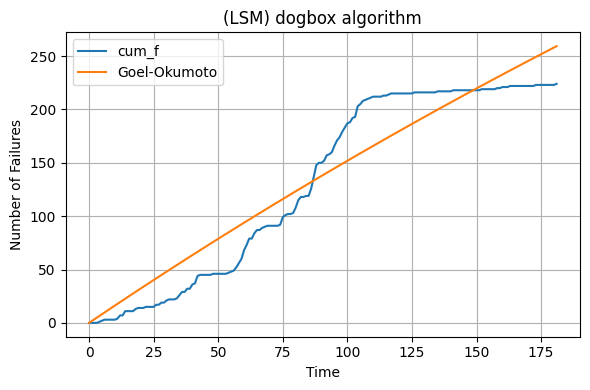

In [12]:
plt.figure(figsize=(6, 4))

plt.plot(t, cum_f, label='cum_f')
plt.plot(t, f_pred, label='Goel-Okumoto')

plt.title('(LSM) dogbox algorithm')
plt.xlabel('Time')
plt.ylabel('Number of Failures')
plt.legend()
plt.grid()
plt.tight_layout()

plt.show()

## MLE

### Nelder-Mead algorithm

In [13]:
result = minimize(goel_okumoto_nll, mle_init_guess, args=(t, f),
                  method='Nelder-Mead', bounds=mle_bounds)

nelder_mead_b = result.x[0]
nelder_mead_a = goel_okumoto_a(t[-1], np.sum(f), nelder_mead_b)
print(f'a: {nelder_mead_a}, b: {nelder_mead_b}')

a: 83051965.79020628, b: 1.4901161193847656e-08


In [14]:
f_pred = goel_okumoto(t, nelder_mead_a, nelder_mead_b)

print(f'MSE: {mean_squared_error(cum_f, f_pred)}')
print(f'RMSE: {root_mean_squared_error(cum_f, f_pred)}')
print(f'MAE: {mean_absolute_error(cum_f, f_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(cum_f, f_pred)}')
print(f'R2 score: {r2_score(cum_f, f_pred)}')

MSE: 1278.6856766496735
RMSE: 35.75871469515751
MAE: 27.337812953895867
MAPE: 183742515832538.12
R2 score: 0.8278017803826203


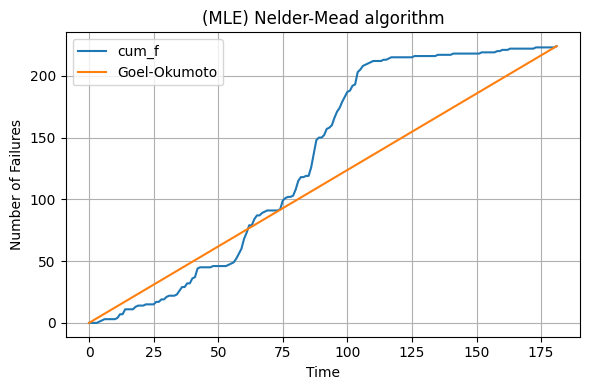

In [15]:
plt.figure(figsize=(6, 4))

plt.plot(t, cum_f, label='cum_f')
plt.plot(t, f_pred, label='Goel-Okumoto')

plt.title('(MLE) Nelder-Mead algorithm')
plt.xlabel('Time')
plt.ylabel('Number of Failures')
plt.legend()
plt.grid()
plt.tight_layout()

plt.show()

### Powell algorithm

In [16]:
result = minimize(goel_okumoto_nll, mle_init_guess, args=(t, f),
                  method='Powell', bounds=mle_bounds)

powell_b = result.x[0]
powell_a = goel_okumoto_a(t[-1], np.sum(f), powell_b)
print(f'a: {powell_a}, b: {powell_b}')

a: 344.4069016558425, b: 0.005806336784801739


In [17]:
f_pred = goel_okumoto(t, powell_a, powell_b)

print(f'MSE: {mean_squared_error(cum_f, f_pred)}')
print(f'RMSE: {root_mean_squared_error(cum_f, f_pred)}')
print(f'MAE: {mean_absolute_error(cum_f, f_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(cum_f, f_pred)}')
print(f'R2 score: {r2_score(cum_f, f_pred)}')

MSE: 822.2927399274352
RMSE: 28.6756471579533
MAE: 25.314083793084162
MAPE: 294901133700778.56
R2 score: 0.8892633675300053


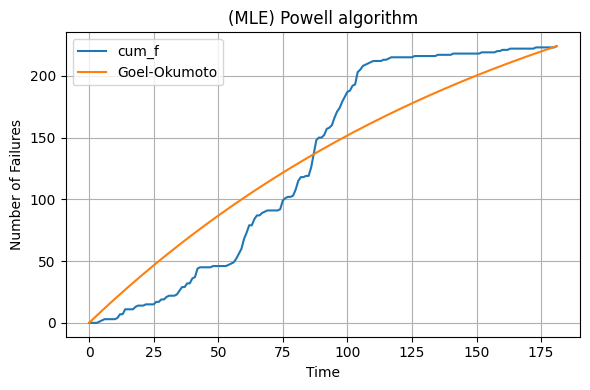

In [18]:
plt.figure(figsize=(6, 4))

plt.plot(t, cum_f, label='cum_f')
plt.plot(t, f_pred, label='Goel-Okumoto')

plt.title('(MLE) Powell algorithm')
plt.xlabel('Time')
plt.ylabel('Number of Failures')
plt.legend()
plt.grid()
plt.tight_layout()

plt.show()

### L-BFGS-B algorithm

In [19]:
result = minimize(goel_okumoto_nll, mle_init_guess, args=(t, f),
                  method='L-BFGS-B', bounds=mle_bounds)

l_bfgs_b_b = result.x[0]
l_bfgs_b_a = goel_okumoto_a(t[-1], np.sum(f), l_bfgs_b_b)
print(f'a: {l_bfgs_b_a}, b: {l_bfgs_b_b}')

a: 344.40707386166565, b: 0.005806331645624089


In [20]:
f_pred = goel_okumoto(t, l_bfgs_b_a, l_bfgs_b_b)

print(f'MSE: {mean_squared_error(cum_f, f_pred)}')
print(f'RMSE: {root_mean_squared_error(cum_f, f_pred)}')
print(f'MAE: {mean_absolute_error(cum_f, f_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(cum_f, f_pred)}')
print(f'R2 score: {r2_score(cum_f, f_pred)}')

MSE: 822.2926874482699
RMSE: 28.675646242905668
MAE: 25.31408271775532
MAPE: 294901021899337.7
R2 score: 0.8892633745972768


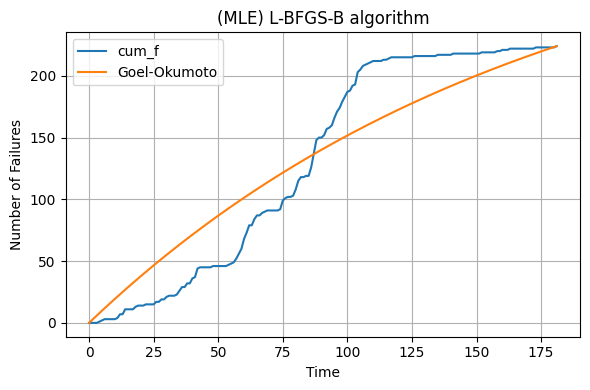

In [21]:
plt.figure(figsize=(6, 4))

plt.plot(t, cum_f, label='cum_f')
plt.plot(t, f_pred, label='Goel-Okumoto')

plt.title('(MLE) L-BFGS-B algorithm')
plt.xlabel('Time')
plt.ylabel('Number of Failures')
plt.legend()
plt.grid()
plt.tight_layout()

plt.show()

### truncated Newton (TNC) algorithm

In [22]:
result = minimize(goel_okumoto_nll, mle_init_guess, args=(t, f),
                  method='TNC', bounds=mle_bounds)

tnc_b = result.x[0]
tnc_a = goel_okumoto_a(t[-1], np.sum(f), tnc_b)
print(f'a: {tnc_a}, b: {tnc_b}')

a: 344.4070743592904, b: 0.005806331630773376


In [23]:
f_pred = goel_okumoto(t, tnc_a, tnc_b)

print(f'MSE: {mean_squared_error(cum_f, f_pred)}')
print(f'RMSE: {root_mean_squared_error(cum_f, f_pred)}')
print(f'MAE: {mean_absolute_error(cum_f, f_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(cum_f, f_pred)}')
print(f'R2 score: {r2_score(cum_f, f_pred)}')

MSE: 822.2926872966215
RMSE: 28.675646240261464
MAE: 25.314082714647935
MAPE: 294901021576264.75
R2 score: 0.889263374617699


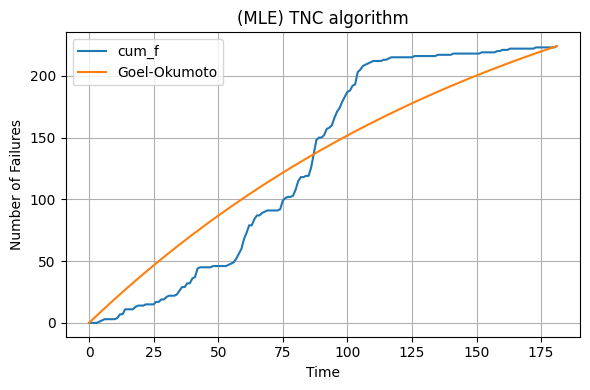

In [24]:
plt.figure(figsize=(6, 4))

plt.plot(t, cum_f, label='cum_f')
plt.plot(t, f_pred, label='Goel-Okumoto')

plt.title('(MLE) TNC algorithm')
plt.xlabel('Time')
plt.ylabel('Number of Failures')
plt.legend()
plt.grid()
plt.tight_layout()

plt.show()

### Constrained Optimization BY Quadratic Approximations (COBYQA) algorithm

In [25]:
result = minimize(goel_okumoto_nll, mle_init_guess, args=(t, f),
                  method='COBYQA', bounds=mle_bounds)

cobyqa_b = result.x[0]
cobyqa_a = goel_okumoto_a(t[-1], np.sum(f), cobyqa_b)
print(f'a: {cobyqa_a}, b: {cobyqa_b}')

a: 344.4068978879968, b: 0.005806336897246527


In [26]:
f_pred = goel_okumoto(t, cobyqa_a, cobyqa_b)

print(f'MSE: {mean_squared_error(cum_f, f_pred)}')
print(f'RMSE: {root_mean_squared_error(cum_f, f_pred)}')
print(f'MAE: {mean_absolute_error(cum_f, f_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(cum_f, f_pred)}')
print(f'R2 score: {r2_score(cum_f, f_pred)}')

MSE: 822.2927410756836
RMSE: 28.675647177974618
MAE: 25.31408381661229
MAPE: 294901136146986.3
R2 score: 0.8892633673753728


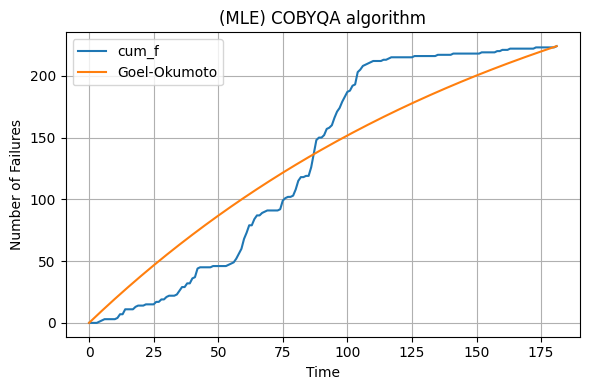

In [27]:
plt.figure(figsize=(6, 4))

plt.plot(t, cum_f, label='cum_f')
plt.plot(t, f_pred, label='Goel-Okumoto')

plt.title('(MLE) COBYQA algorithm')
plt.xlabel('Time')
plt.ylabel('Number of Failures')
plt.legend()
plt.grid()
plt.tight_layout()

plt.show()

### Sequential Least Squares Programming (SLSQP)

In [28]:
result = minimize(goel_okumoto_nll, mle_init_guess, args=(t, f),
                  method='SLSQP', bounds=mle_bounds)

slsqp_b = result.x[0]
slsqp_a = goel_okumoto_a(t[-1], np.sum(f), slsqp_b)
print(f'a: {slsqp_a}, b: {slsqp_b}')

a: 344.4075069391093, b: 0.005806318721239027


In [29]:
f_pred = goel_okumoto(t, slsqp_a, slsqp_b)

print(f'MSE: {mean_squared_error(cum_f, f_pred)}')
print(f'RMSE: {root_mean_squared_error(cum_f, f_pred)}')
print(f'MAE: {mean_absolute_error(cum_f, f_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(cum_f, f_pred)}')
print(f'R2 score: {r2_score(cum_f, f_pred)}')

MSE: 822.2925554731293
RMSE: 28.675643941734407
MAE: 25.314080013446624
MAPE: 294900740732883.6
R2 score: 0.8892633923701233


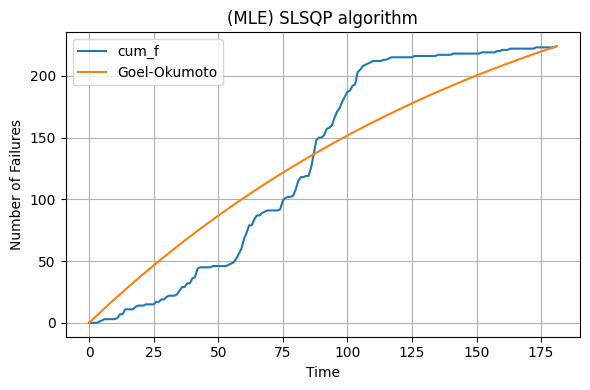

In [30]:
plt.figure(figsize=(6, 4))

plt.plot(t, cum_f, label='cum_f')
plt.plot(t, f_pred, label='Goel-Okumoto')

plt.title('(MLE) SLSQP algorithm')
plt.xlabel('Time')
plt.ylabel('Number of Failures')
plt.legend()
plt.grid()
plt.tight_layout()

plt.show()

### Constrained Trust-Region algorithm

In [31]:
result = minimize(goel_okumoto_nll, mle_init_guess, args=(t, f),
                  method='trust-constr', bounds=mle_bounds)

trust_constr_b = result.x[0]
trust_constr_a = goel_okumoto_a(t[-1], np.sum(f), trust_constr_b)
print(f'a: {trust_constr_a}, b: {trust_constr_b}')

a: 344.3991856062626, b: 0.005806567066809323


In [32]:
f_pred = goel_okumoto(t, trust_constr_a, trust_constr_b)

print(f'MSE: {mean_squared_error(cum_f, f_pred)}')
print(f'RMSE: {root_mean_squared_error(cum_f, f_pred)}')
print(f'MAE: {mean_absolute_error(cum_f, f_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(cum_f, f_pred)}')
print(f'R2 score: {r2_score(cum_f, f_pred)}')

MSE: 822.2950922517019
RMSE: 28.675688173986373
MAE: 25.314131979483317
MAPE: 294906143447328.7
R2 score: 0.8892630507468755


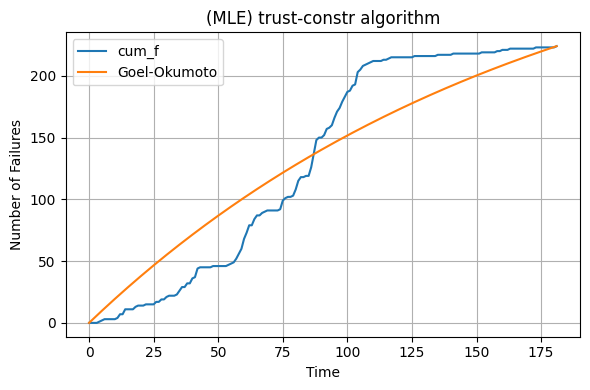

In [33]:
plt.figure(figsize=(6, 4))

plt.plot(t, cum_f, label='cum_f')
plt.plot(t, f_pred, label='Goel-Okumoto')

plt.title('(MLE) trust-constr algorithm')
plt.xlabel('Time')
plt.ylabel('Number of Failures')
plt.legend()
plt.grid()
plt.tight_layout()

plt.show()